### PIMA Dataset data analysis

This notebook looks at the PIMA dataset and builds a model to predict the onset of diabetes

### Imports

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter


import pandas as pd
import numpy as np


# pd.options.mode.chained_assignment = None 

### Helper functions

In [48]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for cm in confusion_matrix_list:
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
    
        
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(1))
    print(tpr_fpr_list)
    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # ax.set_xlim([0,1])
    # ax.set_ylim([0,1])

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
#         plt.plot([fpr, fpr], [0, tpr], 'ks-') # vertical
#         plt.plot([0, fpr], [tpr, tpr], 'ks-') # horizontal
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [27]:
DATASET_NAME = 'dataset/diabetes_pima.csv'
COLUMNS = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']
df = pd.read_csv(DATASET_NAME)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Show statistics of the dataset

In [51]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,31.992578,0.471876,33.240885
std,3.369578,30.435949,12.096346,8.790942,85.021108,7.884160,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,0.000000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [28]:
df_target = df['Outcome']

# Drop the target variable from dataframe
df.drop('Outcome' , inplace = True, axis =1)
df_attr = df
df_attr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


### Preprocessing
Replacing missing values with mean of the columns

In [29]:
imputer = Imputer(missing_values=0, strategy='mean', axis=0)

columns_to_impute = ["Insulin", "Glucose", "BloodPressure", "SkinThickness"]

for columns in columns_to_impute:
    df_attr[columns]=imputer.fit_transform(df[[columns]])
    
df_attr.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33


#### Split attribues for training and testing

In [30]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [31]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Neural Network', LogisticRegression(), 'blue'), 
          ('Random Forest', RandomForestClassifier(), 'yellow')]

predicted_results = []
for model_names, model, _ in models:
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    predicted_results.append(target_predict)

### Results
Show the results of various models

In [32]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_color(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Accuracy Score**

0.755208333333



**Confusion Matrix**

Predicted    0   1
Actual            
0          101  19
1           28  44


**Classification Report**

             precision    recall  f1-score   support

          0       0.78      0.84      0.81       120
          1       0.70      0.61      0.65        72

avg / total       0.75      0.76      0.75       192



**Accuracy Score**

0.791666666667



**Confusion Matrix**

Predicted    0   1
Actual            
0          107  13
1           27  45


**Classification Report**

             precision    recall  f1-score   support

          0       0.80      0.89      0.84       120
          1       0.78      0.62      0.69        72

avg / total       0.79      0.79      0.79       192



**Accuracy Score**

0.755208333333



**Confusion Matrix**

Predicted    0   1
Actual            
0          104  16
1           31  41


**Classification Report**

             precision    recall  f1-score   support

          0       0.77      0.87      0.82       120
          1       0.72      0.57      0.64        72

avg / total       0.75      0.76      0.75       192



### Analysis

[(0.13, 0.56999999999999995), (0.16, 0.60999999999999999), (0.11, 0.62)]


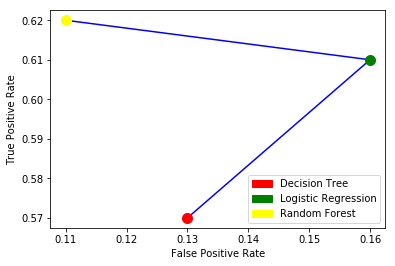

In [49]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')